In [1]:
from google.colab import files
uploaded = files.upload()

Saving Nat_Gas.csv to Nat_Gas.csv


In [2]:
import pandas as pd
df = pd.read_csv('Nat_Gas.csv')  # Replace with the actual file name if different
print(df.head())

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import matplotlib.dates as mdates

df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)


<ipython-input-3-2f794f4b32be>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


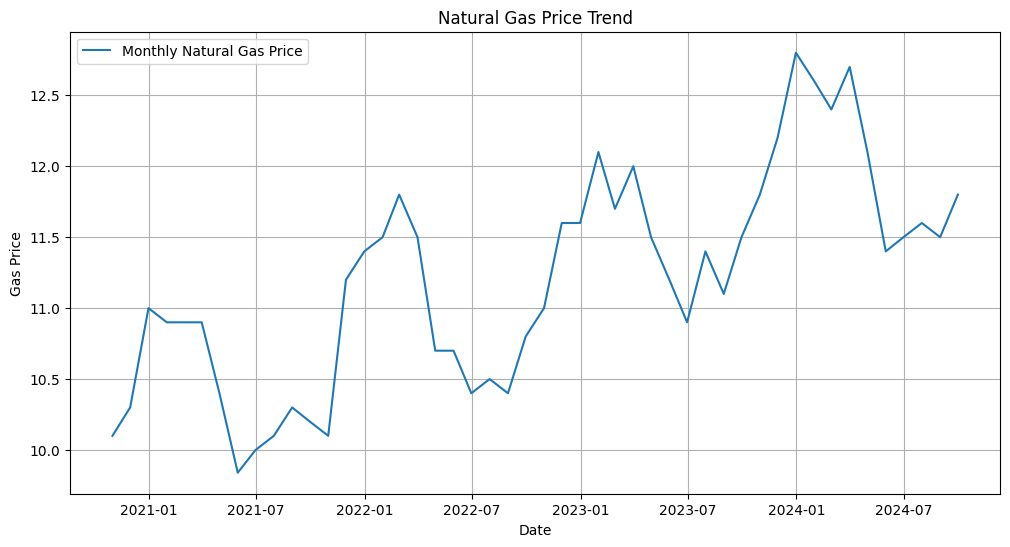

In [4]:
# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], label='Monthly Natural Gas Price')
plt.title('Natural Gas Price Trend')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.grid(True)
plt.legend()
plt.show()

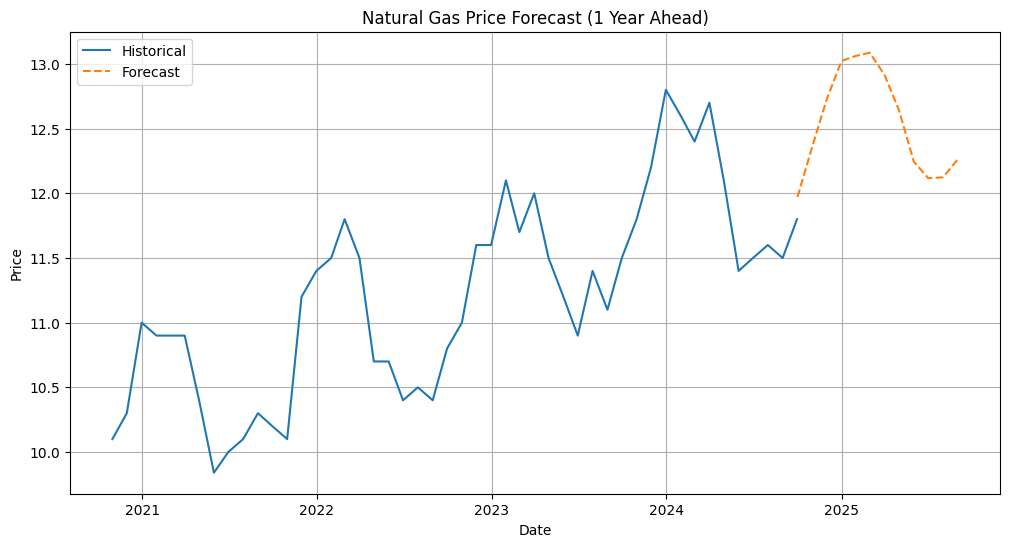

In [5]:
# Look at daily prices, because we dont want to just estimate it at the beginning of each month
daily = df.resample('D').interpolate()
# Smooth the price in order to aviod overfitting
df['Smoothed_Prices'] = df['Prices'].rolling(window=3, center=True).mean()
stl = STL(df['Smoothed_Prices'].dropna(), period=12)
# STL Decomposition for trend + seasonality + residual
res = stl.fit()
trend = res.trend
seasonal = res.seasonal
resid = res.resid

# Extend trend using Linear Regression
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values
model = LinearRegression().fit(X, y)

# Extrapolate 12 months in advance
future_dates = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_index = np.arange(len(trend), len(trend) + len(future_dates)).reshape(-1, 1)
future_trend = model.predict(future_index)
seasonality_pattern = seasonal[-12:].values
future_seasonal = np.tile(seasonality_pattern, int(len(future_dates)/12) + 1)[:len(future_dates)]

# Build future price estimate
future_price = future_trend + future_seasonal
future_df = pd.DataFrame({'Prices': future_price}, index=future_dates)
combined = pd.concat([df, future_df])

# Plot data with forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Prices'], label='Historical')
plt.plot(future_df.index, future_df['Prices'], label='Forecast', linestyle='--')
plt.title('Natural Gas Price Forecast (1 Year Ahead)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
full_daily = combined.resample('D').interpolate()


In [6]:
def get_price_on_date(date_str):
    """
    Input: date (e.g., '2024-12-25')
    Output: Estimated price
    """
    date = pd.to_datetime(date_str)
    if date < full_daily.index[0] or date > full_daily.index[-1]:
        return f"Date out of range. Try a date between {full_daily.index[0].date()} and {full_daily.index[-1].date()}"
    price = full_daily.loc[date, 'Prices']
    return float(price)

In [7]:
def price_gas_storage_contract(injection_dt,withdrawal_dt,injection_rt,withdrawal_rt,max_storage,monthly_storage_cost):
    """
    Parameters:
        injection_dt: Dates when gas is injected.
        withdrawal_dt: Dates when gas is withdrawn.
        injection_rt: Units of gas injected per injection day.
        withdrawal_rt: Units of gas withdrawn per withdrawal day.
        max_storage: Maximum volume that can be stored.
        monthly_storage_cost: Flat storage cost per month.
    Returns:
        Net present value (NPV) of the contract.
    """
    from collections import defaultdict

    storage = defaultdict(float)
    cash_flows = defaultdict(float)
    storage_level = 0

    all_dates = sorted(set(injection_dt + withdrawal_dt))
    monthly_flags = set()

    for day in pd.date_range(min(all_dates), max(all_dates)):
        # Injection
        if day in injection_dt:
            if storage_level + injection_rt <= max_storage:
                storage_level += injection_rt
                cash_flows[day] -= get_price_on_date(day) * injection_rt
            else:
                amount = max_storage - storage_level
                storage_level += amount
                cash_flows[day] -= get_price_on_date(day) * amount

        # Withdrawal
        if day in withdrawal_dt:
            if storage_level >= withdrawal_rt:
                storage_level -= withdrawal_rt
                cash_flows[day] += get_price_on_date(day) * withdrawal_rt
            else:
                amount = storage_level
                storage_level = 0
                cash_flows[day] += get_price_on_date(day) * amount

        # Track storage and flag the month if volume > 0
        storage[day] = storage_level
        if storage_level > 0:
            monthly_flags.add((day.year, day.month))

    # Storage Costs
    for year, month in monthly_flags:
        cost_date = pd.Timestamp(f"{year}-{month:02d}-01")
        cash_flows[cost_date] -= monthly_storage_cost

    total_value = sum(cash_flows.values())
    return total_value


In [8]:
print(get_price_on_date('2024-11-15'))

12.532843955417245
